In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
)

In [2]:
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx]["id"]) + ".png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            return image, label
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)

In [3]:
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "dataset/train/images"
test_images_path = "dataset/val/images"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:
train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [6]:
class ResNet50Model(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler()

num_epochs = 20

C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sushm\miniconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\sushm/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [08:36<00:00, 199kB/s]


In [8]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    scheduler.step()


Epoch 1/20, Loss: 0.3286, Accuracy: 0.8492, Precision: 0.8494, Recall: 0.8494, F1-Score: 0.8492
Epoch 2/20, Loss: 0.2059, Accuracy: 0.9168, Precision: 0.9170, Recall: 0.9170, F1-Score: 0.9168
Epoch 3/20, Loss: 0.1661, Accuracy: 0.9330, Precision: 0.9329, Recall: 0.9330, F1-Score: 0.9330
Epoch 4/20, Loss: 0.1235, Accuracy: 0.9562, Precision: 0.9562, Recall: 0.9562, F1-Score: 0.9562
Epoch 5/20, Loss: 0.1096, Accuracy: 0.9582, Precision: 0.9582, Recall: 0.9583, F1-Score: 0.9582
Epoch 6/20, Loss: 0.1106, Accuracy: 0.9577, Precision: 0.9577, Recall: 0.9576, F1-Score: 0.9576
Epoch 7/20, Loss: 0.0777, Accuracy: 0.9727, Precision: 0.9726, Recall: 0.9727, F1-Score: 0.9727
Epoch 8/20, Loss: 0.0603, Accuracy: 0.9818, Precision: 0.9818, Recall: 0.9818, F1-Score: 0.9818
Epoch 9/20, Loss: 0.0770, Accuracy: 0.9756, Precision: 0.9756, Recall: 0.9756, F1-Score: 0.9756
Epoch 10/20, Loss: 0.0545, Accuracy: 0.9829, Precision: 0.9829, Recall: 0.9830, F1-Score: 0.9829
Epoch 11/20, Loss: 0.0320, Accuracy: 0.

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       719
           1       0.97      0.99      0.98       740

    accuracy                           0.98      1459
   macro avg       0.98      0.98      0.98      1459
weighted avg       0.98      0.98      0.98      1459

Accuracy: 0.9787525702535984
Precision: 0.9789564949182634
Recall: 0.9786396271097244
F1-Score: 0.9787423442782366


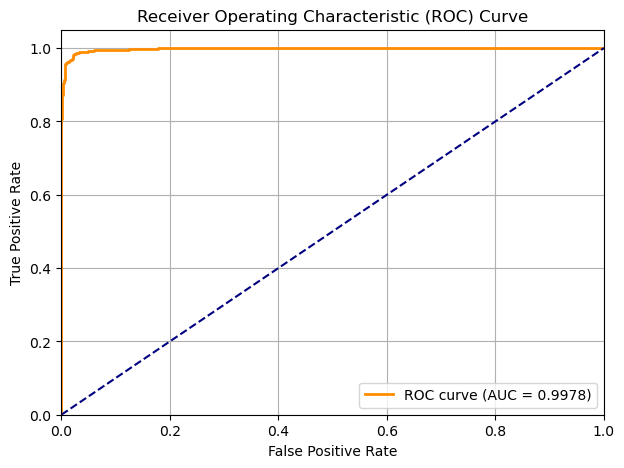

Model saved at Models/resnet50_internal_waves.pth


In [10]:
import matplotlib.pyplot as plt

model.eval()
predictions, image_ids, probs = [], [], []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})
predictions_df["id"] = predictions_df["id"].astype(str)
merged_df = pd.merge(predictions_df, solutions_df, on="id")

y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

save_dir = "Models/"  
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "resnet50_internal_waves.pth")
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")